# Dynamics of recall buffer memory.
The idea is that tau_z / recall time = 'number of states available on memory'. In order for the sequence to disambiguate an overlap we need to have extension > overlap + 1. 

In [1]:
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline

np.set_printoptions(suppress=True, precision=2)

sns.set(font_scale=2.0)

In [2]:
run_old_version = False
if run_old_version:
    hash_when_file_was_written = '39561b3c986fbbf3acad97a1a66ea8f59c4c508c'
    hash_at_the_moment = subprocess.check_output(["git", 'rev-parse', 'HEAD']).strip()
    print('Actual hash', hash_at_the_moment)
    
    print('Hash of the commit used to run the simulation', hash_when_file_was_written)
    subprocess.call(['git', 'checkout', hash_when_file_was_written])

In [3]:
from network import Protocol, BCPNNFast, NetworkManager
from analysis_functions import calculate_timings

In [4]:
tolerance = 5
import sklearn.linear_model as linear
def calculate_extensions(w_small, tolerance, n_patterns):
    extensions = []
    extensions_decay = []
    total = n_patterns - tolerance
    for i in range(tolerance, total):
        w_column = w_small[:n_patterns, i]
        w_column = w_column[w_column > 0]
        
        # Get the extension
        extensions.append(w_column.size)
        
        # Get the decay
        aux = np.copy(w_column)
        aux -= aux[0]
        x = np.arange(0, len(aux), 1)
        x = x[:, np.newaxis]
        
        reg = linear.LinearRegression(fit_intercept=False)
        reg.fit(x, aux)
        extensions_decay.append(-reg.coef_[0])
    
    extension_decay = np.mean(extensions_decay)
    extension = int(np.median(extensions))
    
    return extension, extension_decay

## Recall time as a function of tau_z

In [5]:
# Patterns parameters
hypercolumns = 4
minicolumns = 40
n_patterns = 30

dt = 0.001

# Timings parameters
tau_z_pre = 0.150
tau_p = 10.0

# Traiming parameters
training_times = 0.100
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
epochs = 3

n = 5
T_cue = 0.100
T_recall = 10.0

patterns_indexes = [i for i in range(n_patterns)]

tau_z_pre_vector = np.arange(0.100, 1.100, 0.100)

In [6]:
mean_recall_time_tau_z = []
std_recall_time_tau_z = []
extensions_tau_z = []

for tau_z_pre in tau_z_pre_vector:
    print(tau_z_pre)
    nn = BCPNNFast(hypercolumns=hypercolumns, minicolumns=minicolumns, tau_z_pre=tau_z_pre)
    manager = NetworkManager(nn, dt=dt, values_to_save=['o'])
    simple_protocol = Protocol()
    simple_protocol.simple_protocol(patterns_indexes=patterns_indexes, training_time=training_times,
                                    inter_sequence_interval=inter_sequence_interval, epochs=epochs)

    manager.run_network_protocol(simple_protocol, verbose=False)
    manager.run_network_recall(T_recall=T_recall, T_cue=T_cue, I_cue=patterns_indexes[0])

    timings = calculate_timings(manager, remove=0.010)
    recall_times = [x[1] for x in timings[1:-1]]
    mean_recall_time_tau_z.append(np.mean(recall_times))
    std_recall_time_tau_z.append(np.std(recall_times))
    
    w_small = nn.w[:n_patterns, :n_patterns]
    extension, decay = calculate_extensions(w_small, tolerance, n_patterns)
    extensions_tau_z.append(extension)

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


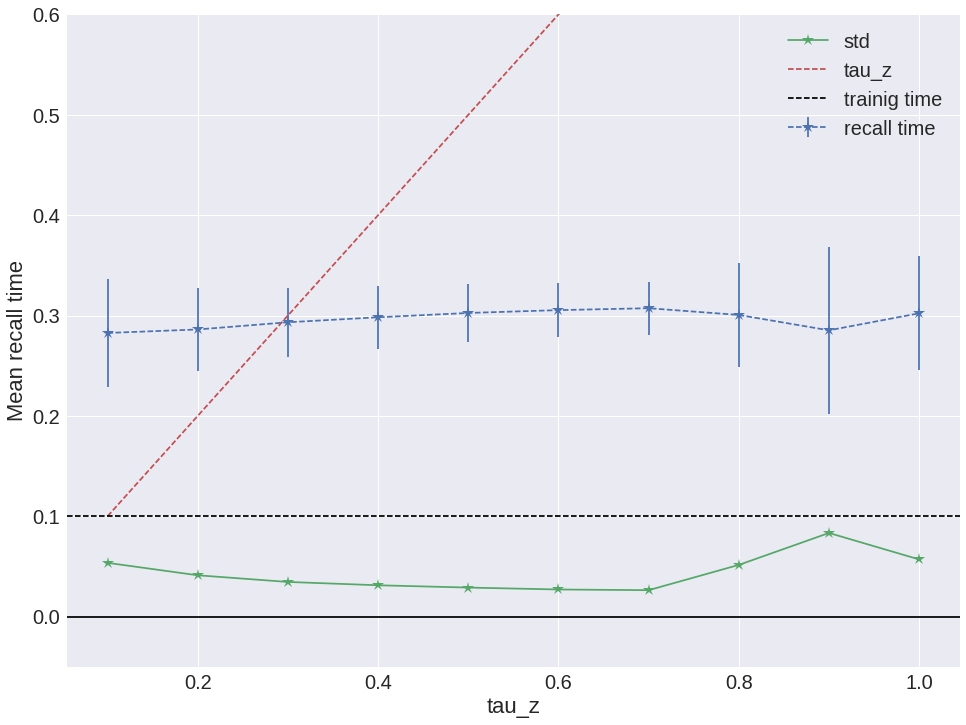

In [25]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
# ax.plot(tau_z_pre_vector, mean_recall_time, '*-', markersize=13, label='recall time')
ax.errorbar(tau_z_pre_vector, mean_recall_time_tau_z, yerr=std_recall_time_tau_z, 
            fmt='*--', markersize=13, label='recall time')
ax.plot(tau_z_pre_vector, std_recall_time_tau_z, '*-', markersize=13, label='std')
ax.plot(tau_z_pre_vector, tau_z_pre_vector, '--', label='tau_z')

ax.axhline(0.0, ls='-', color='black')
ax.axhline(0.100, ls='--', color='black', label='trainig time')

ax.set_xlabel('tau_z')
ax.set_ylabel('Mean recall time')

ax.set_ylim([-0.05, 0.6])
ax.legend();

#### Extension and memory buffer

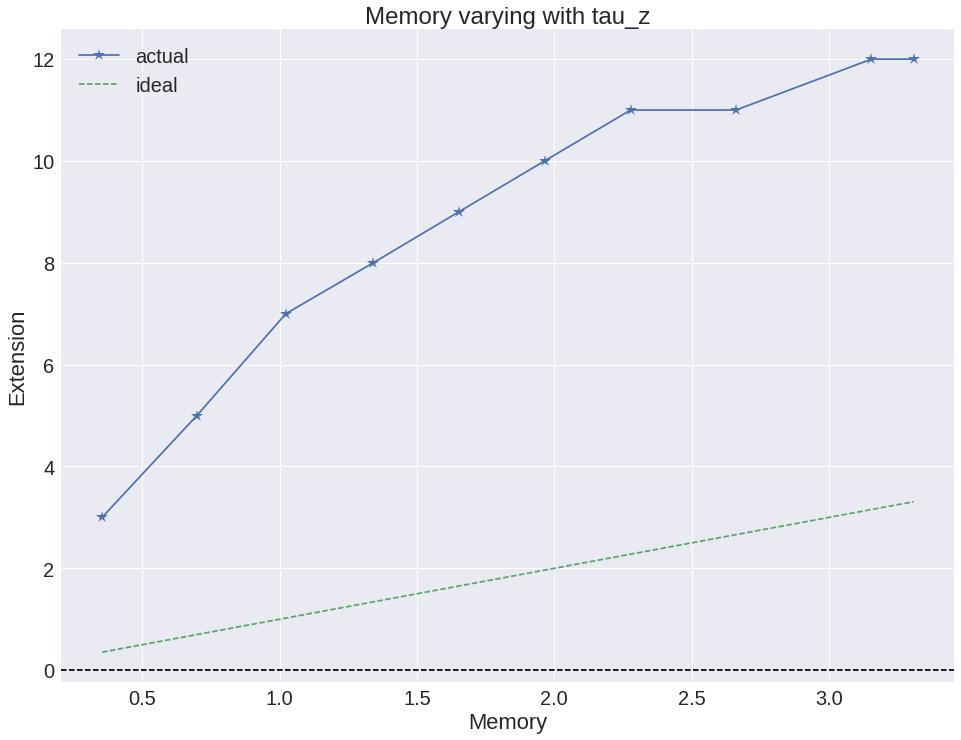

In [20]:
memory = [tau_z_pre / recall_time for (tau_z_pre, recall_time) in zip(tau_z_pre_vector, mean_recall_time_tau_z)]

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(memory, extensions_tau_z, '*-', markersize=13, label='actual')
ax.plot(memory , memory, '--', label='ideal')

ax.axhline(0.0, ls='--', color='black')

ax.set_xlabel('Memory')
ax.set_ylabel('Extension')

ax.set_title('Memory varying with tau_z')

ax.legend();

## Recall time as a function of training time

In [9]:
hypercolumns = 4
minicolumns = 40
n_patterns = 30

dt = 0.001

# Timings parameters
tau_z_pre = 0.150
tau_p = 10.0

# Traiming parameters
training_times = 0.100
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
epochs = 3

T_cue = 0.100
T_recall = 10.0

patterns_indexes = [i for i in range(n_patterns)]

training_times_vector = np.arange(0.100, 1.100, 0.100)

In [10]:
mean_recall_time = []
std_recall_time = []
extensions = []

for training_times in training_times_vector:
    print(training_times)
    nn = BCPNNFast(hypercolumns=hypercolumns, minicolumns=minicolumns, tau_z_pre=tau_z_pre)
    manager = NetworkManager(nn, dt=dt, values_to_save=['o'])
    simple_protocol = Protocol()
    simple_protocol.simple_protocol(patterns_indexes=patterns_indexes, training_time=training_times,
                                    inter_sequence_interval=inter_sequence_interval, epochs=epochs)

    manager.run_network_protocol(simple_protocol, verbose=False)
    manager.run_network_recall(T_recall=T_recall, T_cue=T_cue, I_cue=patterns_indexes[0])

    timings = calculate_timings(manager, remove=0.010)
    recall_times = [x[1] for x in timings[1:-1]]
    mean_recall_time.append(np.mean(recall_times))
    std_recall_time.append(np.std(recall_times))
    
    w_small = nn.w[:n_patterns, :n_patterns]
    extension, decay = calculate_extensions(w_small, tolerance,  n_patterns)
    extensions.append(extension)

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


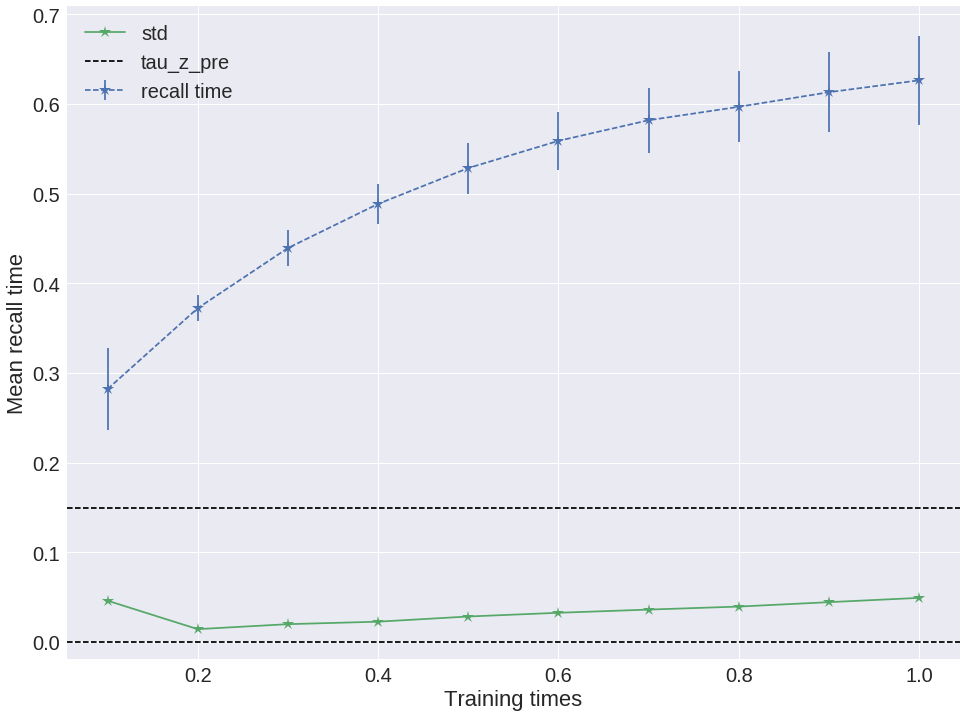

In [19]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.errorbar(training_times_vector, mean_recall_time, yerr=std_recall_time, fmt='*--', markersize=13, label='recall time')
ax.plot(training_times_vector, std_recall_time, '*-', markersize=13, label='std')

ax.axhline(0.0, ls='--', color='black')
ax.axhline(tau_z_pre, ls='--', color='black', label='tau_z_pre')

ax.set_xlabel('Training times')
ax.set_ylabel('Mean recall time')

ax.legend();

#### Extension as a function of memory buffer

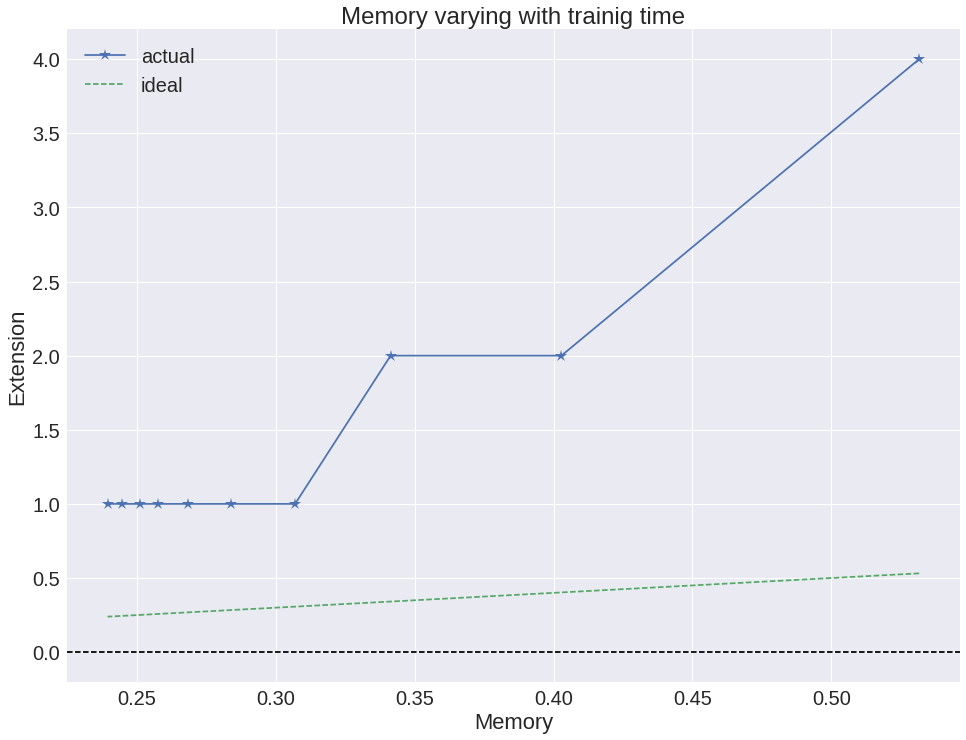

In [13]:
memory = [tau_z_pre / x for x in mean_recall_time]

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(memory, extensions, '*-', markersize=13, label='actual')
ax.plot(memory , memory, '--', label='ideal')

ax.axhline(0.0, ls='--', color='black')

ax.set_xlabel('Memory')
ax.set_ylabel('Extension')

ax.set_title('Memory varying with trainig time')

ax.legend();

#### Git machinery

In [ ]:
if run_old_version:
    subprocess.call(['git', 'checkout', 'master'])